<span style="font-size: 36px;"> ---------------</span>


<span style="font-size: 36px;"> **Data Process**</span>


<span style="font-size: 36px;"> ---------------</span>

In [ ]:
import os
import torch as torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

def plot_gradients_weights(grads, weights):
    assert len(grads) == len(weights), "grads and weights arrays must have the same length"

    # Create log-log plot
    plt.plot(range(len(grads)), grads, label='Gradients')

    # Set plot labels and title
    plt.xlabel('Steps')
    plt.ylabel('Gradients')
    plt.title('Gradients')

    # Add legend



    plt.legend()
    plt.yscale('log')

    # Display the plot
    plt.show()


    plt.plot(range(len(weights)), weights, label='Weights')
        # Set plot labels and title
    plt.xlabel('Steps')
    plt.ylabel('Weight')
    plt.title('Weight')

    # Add legend
    plt.legend()
    plt.yscale('log')

    # Display the plot
    plt.show()


In [ ]:
dir_path = r'/content/drive/MyDrive/VONG/polyvore_1000_cleaned'
device

device(type='cpu')

In [ ]:


# Path to files
dir_path = r'/home/coreman/Documents/AEGIS/vong/polyvore_1000_cleaned/'
dir_path = r'/content/drive/'
dir_path = r'/content/drive/MyDrive/VONG/polyvore_1000_cleaned'
# List to store file paths
f = []

# Walk through the directory and its subdirectories
for dirpath, dirnames, filenames in os.walk(dir_path):
    for filename in filenames:
        # Create the full path to the file and append it to the list
        file_path = os.path.join(dirpath, filename)
        f.append(file_path)

# Now, 'f' contains the full paths of all files in the directory and its subdirectories



In [ ]:



# image_sizes = set()
# ## read files and check sizes
# for filename in f:
#     if filename.endswith(".jpg"): # to avoid dead dirs
#         with Image.open(filename) as img:
#             image_sizes.add(img.size)

# print(image_sizes)


In [ ]:
# output_size = (128, 128)

# #change size to
# for filename in f:
#         with Image.open(filename) as img:
#             img_resized = img.resize(output_size, Image.ANTIALIAS)
#             img_resized.save(filename)


<span style="font-size: 36px;"> ---------------</span>


<span style="font-size: 36px;"> **Auto-Encoder**</span>


<span style="font-size: 36px;"> ---------------</span>

In [ ]:
#### ADD TEST DATA PICKER - NEEDS OPTIMIZATION

# Path to files
dir_path = dir_path+'/Bags/'

# List to store file paths
f = []
imgs_ = []

# Walk through the directory and its subdirectories
for dirpath, dirnames, filenames in os.walk(dir_path):
    for filename in filenames:
        # Create the full path to the file and append it to the list
        file_path = os.path.join(dirpath, filename)
        f.append(file_path)


        # Convert grayscale images to RGB
        with Image.open(file_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')


            imgs_.append(np.asarray(img))


#### ADD TEST DATA PICKER - NEEDS OPTIMIZATION


In [ ]:


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),  # assuming RGB images
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_embeddings(self, x):
        return self.encoder(x)



In [ ]:
#initialize the autoencoder
autoencoder = Autoencoder()
autoencoder.to(device)


imgs  = np.array(imgs_)[0:200]
val_imgs = np.array(imgs_)[200:210]


#Sample input (batch_size, channels, height, width)
input_data =  torch.from_numpy(imgs).to(device).permute(0, 3, 1, 2).float()/255.0 # torch.rand((5, 3, output_size[0], output_size[1]))  # assuming size is give by earlier defined output_size

## same for validation
val_input_data = torch.from_numpy(val_imgs).permute(0, 3, 1, 2).float() / 255.0


# Get embeddings for the sample input
embeddings = autoencoder.get_embeddings(input_data)
print(np.shape(embeddings)) # NUMBER OF "characteristics"




torch.Size([200, 16, 64, 64])


In [ ]:


# Assuming you have already defined your Autoencoder class and instantiated it as 'autoencoder'

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training parameters
num_epochs = 400  # or however many you need
batch_size = 5

## data creation
data_loader = torch.utils.data.DataLoader(input_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_input_data, batch_size=batch_size, shuffle=False)


losses       = []
val_losses   = []
nn_weights   = []
nn_grads     = []

#Training loop
for epoch in range(num_epochs):
    train_loss = 0
    #Train on batches
    for batch_data in data_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(batch_data.to(device))
        loss         =  criterion(outputs, batch_data)
        train_loss  +=  loss.to('cpu').detach().numpy()
        # Backward pass
        loss.backward()

        ##############monitoring of NN
        for p in autoencoder.parameters():
            if p.grad is not None:
                nn_weights.append(p.grad.data.abs().mean().item())
        for p in autoencoder.parameters():
            nn_grads.append(p.data.abs().mean().item())
        ##############monitoring of NN

        # and optimize
        optimizer.step()
    avg_tr_loss = train_loss / len(data_loader)
    losses.append(avg_tr_loss)
    val_loss = 0
    with torch.no_grad():  # Deactivate gradients for validation
        for batch_val in val_data_loader:
            outputs_val = autoencoder(batch_val.to(device))
            val_loss += criterion(outputs_val, batch_val.to(device)).cpu().detach().numpy()
    avg_val_loss = val_loss / len(val_data_loader)
    val_losses.append(avg_val_loss)
    if epoch % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_tr_loss:.5f}, Val Loss: {avg_val_loss:.5f}")

print("Training finished.")

Epoch [1/400], Train Loss: 0.12982, Val Loss: 0.04306
Epoch [101/400], Train Loss: 0.00146, Val Loss: 0.00122
Epoch [201/400], Train Loss: 0.00115, Val Loss: 0.00098
Epoch [301/400], Train Loss: 0.00108, Val Loss: 0.00091
Training finished.


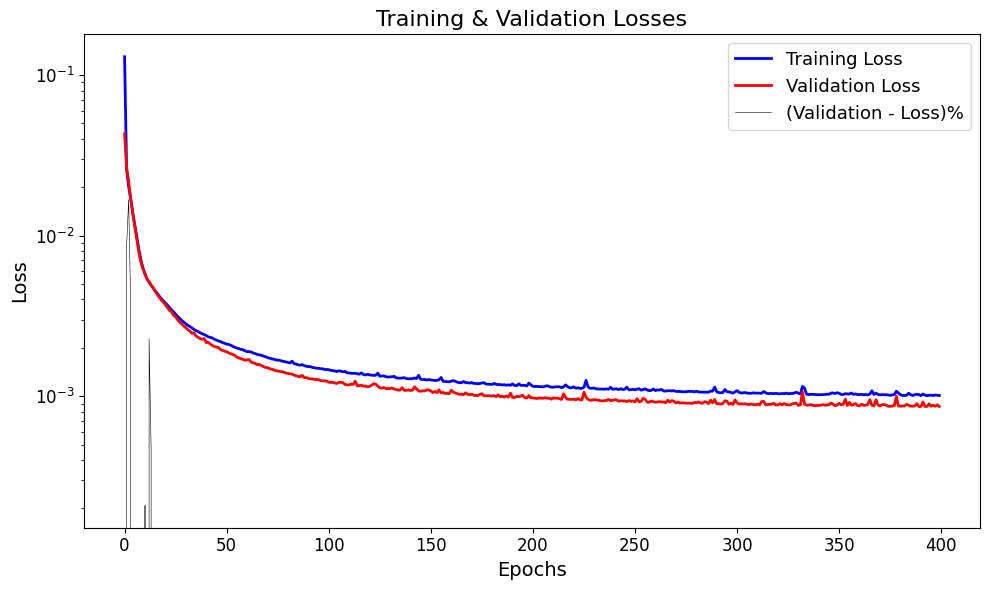

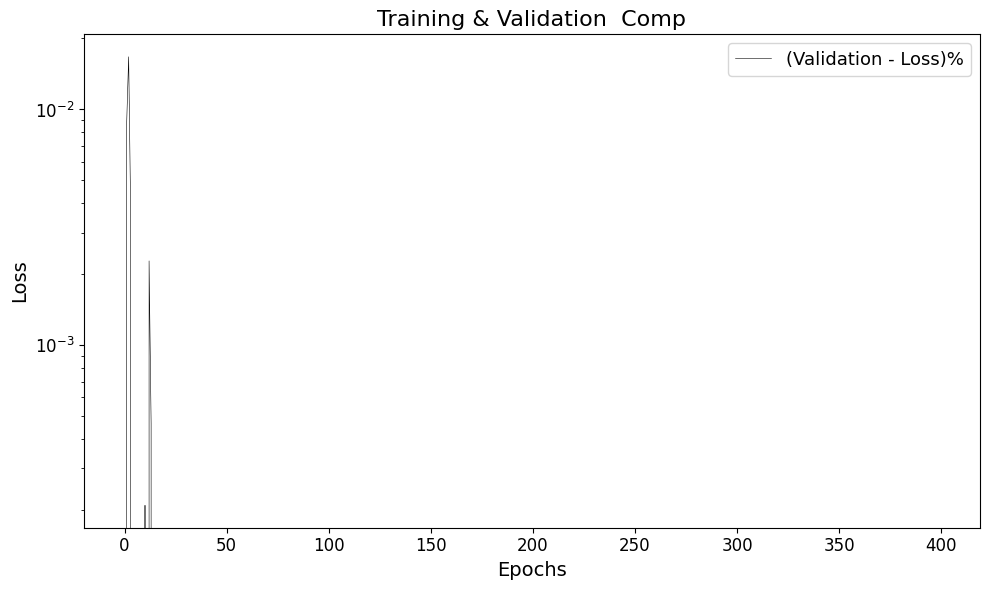

In [ ]:
# Define some aesthetic configurations
plt.figure(figsize=(10, 6))  # Set figure size
plt.title('Training & Validation Losses', fontsize=16)  # Set a title for the plot
#plt.grid(True, which="both", ls="--", c='0.65')  # Display a grid with a custom style
val_losses = np.array(val_losses)
losses     = np.array(losses)
#plotting data
plt.plot(losses, label='Training Loss', color='blue', lw=2)  # lw is for line width
plt.plot(val_losses, label='Validation Loss', color='red', lw=2)
plt.plot((val_losses-losses)/(val_losses+losses)/2, label='(Validation - Loss)%', color='black', lw=0.4)
#axes settings
plt.yscale('log')  # Set y-axis to log scale for better visualization
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.legend(fontsize=13, loc='upper right')  # Set fontsize for the legend and its location

plt.tight_layout()  # Adjusts the plot, so everything fits perfectly
plt.show()


# Define some aesthetic configurations
plt.figure(figsize=(10, 6))  # Set figure size
plt.title('Training & Validation  Comp', fontsize=16)  # Set a title for the plot
#plt.grid(True, which="both", ls="--", c='0.65')  # Display a grid with a custom style
val_losses = np.array(val_losses)
losses     = np.array(losses)
#plotting data
plt.plot((val_losses-losses)/(val_losses+losses)/2, label='(Validation - Loss)%', color='black', lw=0.4)
#axes settings
plt.yscale('log')  # Set y-axis to log scale for better visualization
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.legend(fontsize=13, loc='upper right')  # Set fontsize for the legend and its location

plt.tight_layout()  # Adjusts the plot, so everything fits perfectly
plt.show()


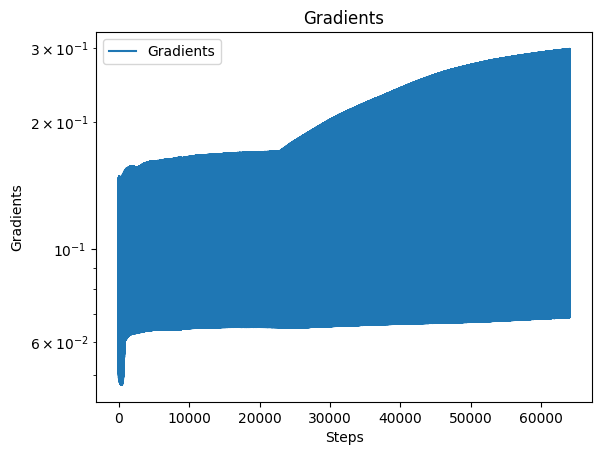

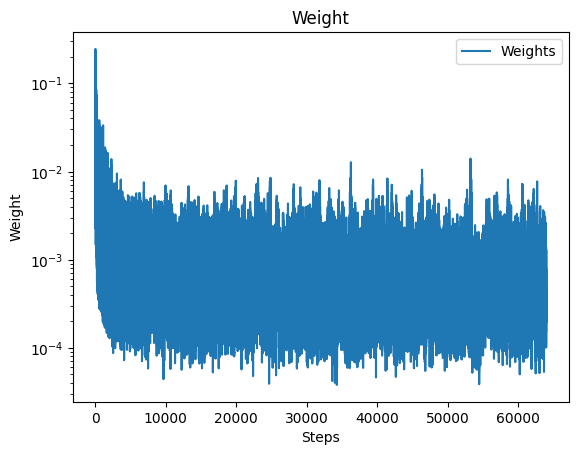

In [ ]:
plot_gradients_weights(nn_grads, nn_weights)

In [ ]:
image_tensor = val_input_data[0]

In [ ]:
# Assuming your image tensor is named 'image_tensor'
image_tensor = image_tensor.to(device)  # If you're using a GPU

# Pass through autoencoder
encoded = autoencoder.encoder(image_tensor)
decoded = autoencoder.decoder(encoded)


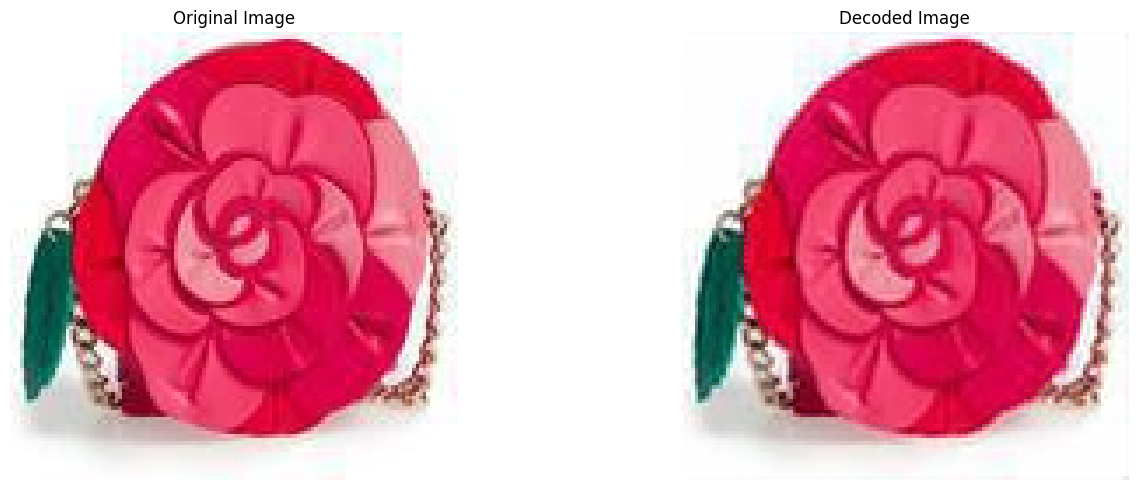

In [ ]:
def imshow(img_tensor, ax, title=None):
    img = img_tensor.cpu().detach().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')  # Hide axes

#plot stff

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#original Image
imshow(image_tensor, ax=axes[0], title="Original Image")



#decoded Image
imshow(decoded, ax=axes[1], title="Decoded Image")

plt.tight_layout()
plt.show()
